**Zillow:**  
Zillow is an online real estate database company founded in 2006  
  
**Zestimate:**
"Zestimates" are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today)  
  
**Objective:**  
Building a model to improve the Zestimate residual error.  
  
The competition is in two stages. This public competition will go on till Jan 2018 and has $50,000 in prize. Please make sure to read about the Prize details and Competition overview since it is quite different in this one.  
  
Let us first import the necessary modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import warnings
warnings.ignore

In [2]:
from subprocess import check_output
print(check_output(['ls', './zillow-prize-1/']).decode('utf8'))

properties_2016.csv
properties_2017.csv
sample_submission.csv
train_2016_v2.csv
train_2017.csv
zillow_data_dictionary.xlsx



In [3]:
train_df = pd.read_csv('./zillow-prize-1/train_2016_v2.csv', parse_dates=['transactiondate'])
train_df.shape

(90275, 3)

In [4]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


**Logerror:**  
Target vaiable for this competition is 'logerrer' field. So let us do some analysis on this field first.

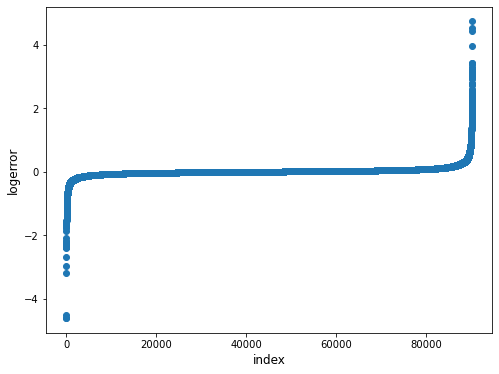

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This look nice with some outliers at both the ends.  
Let us remove the outliers and then do a histogram plot on the same.

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


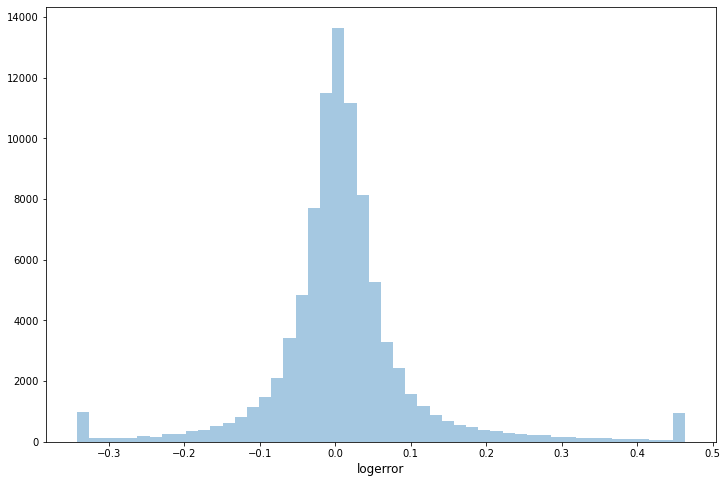

In [8]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)

train_df['logerror'].iloc[train_df['logerror'] > ulimit] = ulimit
train_df['logerror'].iloc[train_df['logerror'] < llimit] = llimit

plt.figure(figsize=(12, 8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

**Transaction Date:**  
Now let us explore the date field. Let us first check the number of transaction in each month.

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


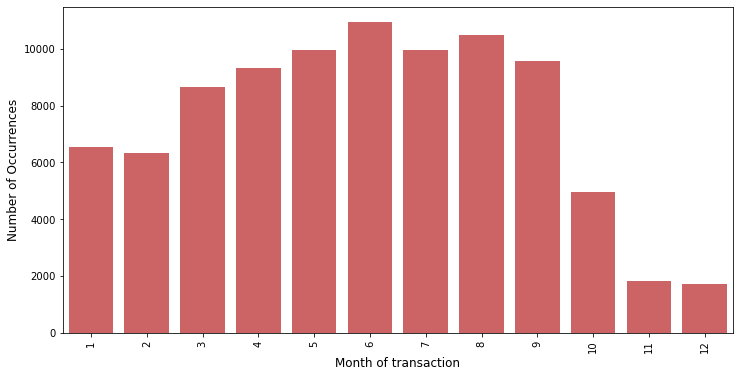

In [9]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

As we could see from the data page as well. *The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.*  
  
So we have shorter bars in the last three months.

**Parcel Id:**

In [10]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

So most of the parcel ids are appearing only once in the dataset.

**Properties 2016:**  

In [11]:
prop_df = pd.read_csv('./zillow-prize-1/properties_2016.csv')
prop_df.shape

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2985217, 58)

In [12]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


There are so many NaN values in the dataset. So let us first do some exploration on that one.

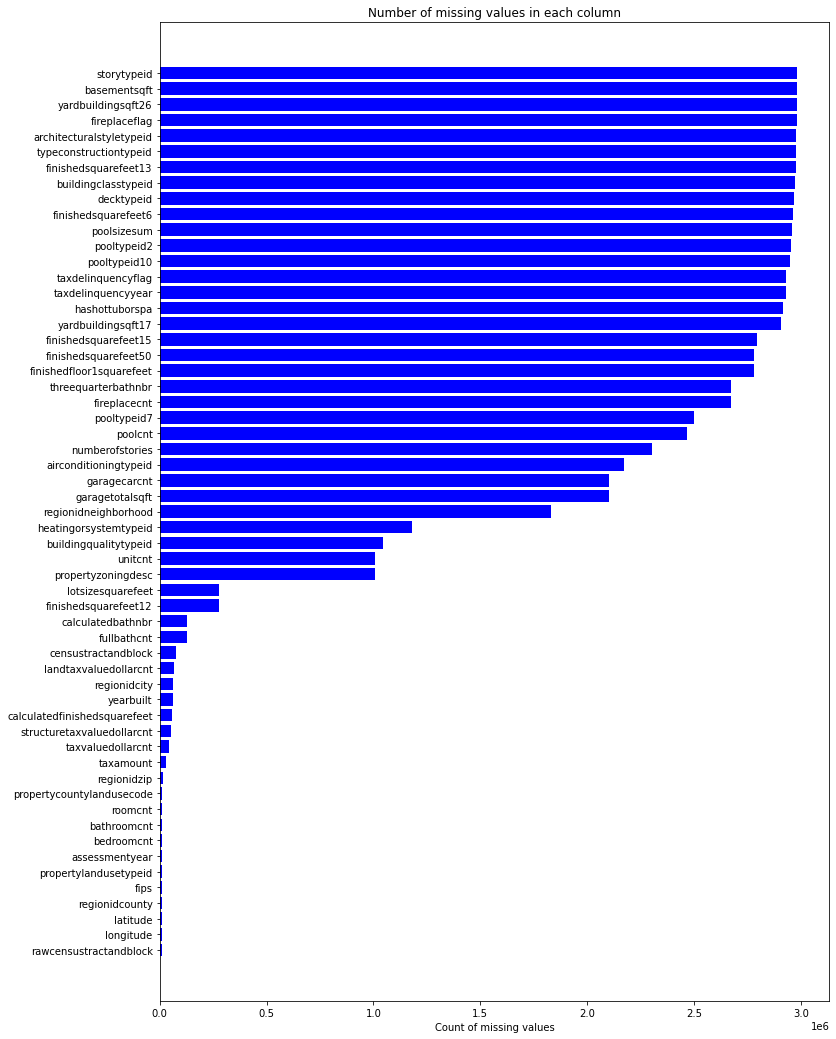

In [15]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9

fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel('Count of missing values')
ax.set_title('Number of missing values in each column')
plt.show()

Let us explore the latitude and longitude variable to begin with.

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

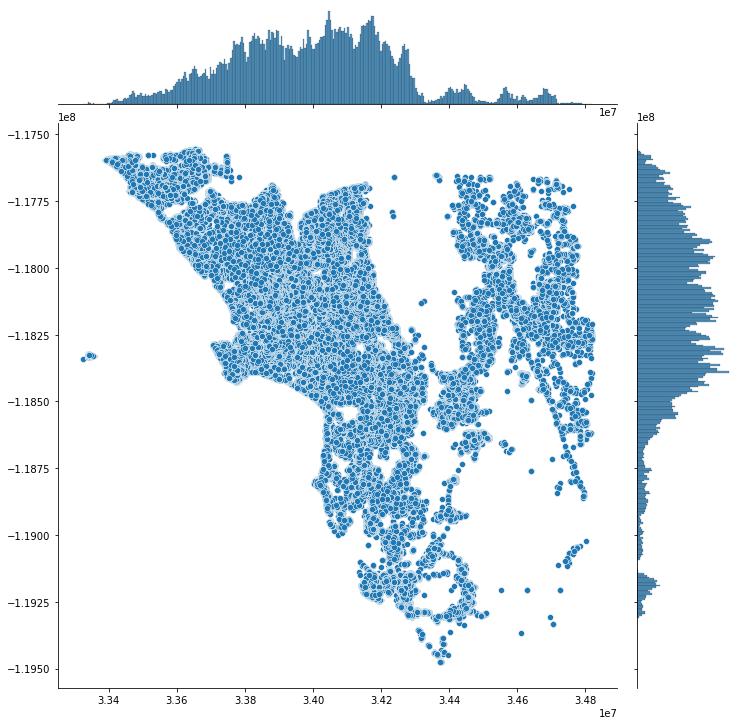

In [17]:
plt.figure(figsize=(12, 12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

From the data page, *we are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.*  
  
We have about 90,275 rows in train but we have about 2,985,217 rows in properties file. So let us merge the two files and then carry out analysis.

In [21]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Let us check the dtypes of different types of variable.

In [22]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


Almost all are float variables with few object (categorical) variables. Let us get the count.

In [23]:
dtype_df.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


Let us check the number of Nulls in this new merged dataset.

In [24]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df[missing_df['missing_ratio'] > 0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


Four columns have missing values 99.9% of the times.

**Univariate Analysis:**  
  
Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

/var/folders/ny/473vxrss0zd4s69y33w2wprr0000gn/T/ipykernel_7715/2719197408.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_values = train_df.mean(axis=0)
/var/folders/ny/473vxrss0zd4s69y33w2wprr0000gn/T/ipykernel_7715/2719197408.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_values = train_df.mean(axis=0)
/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


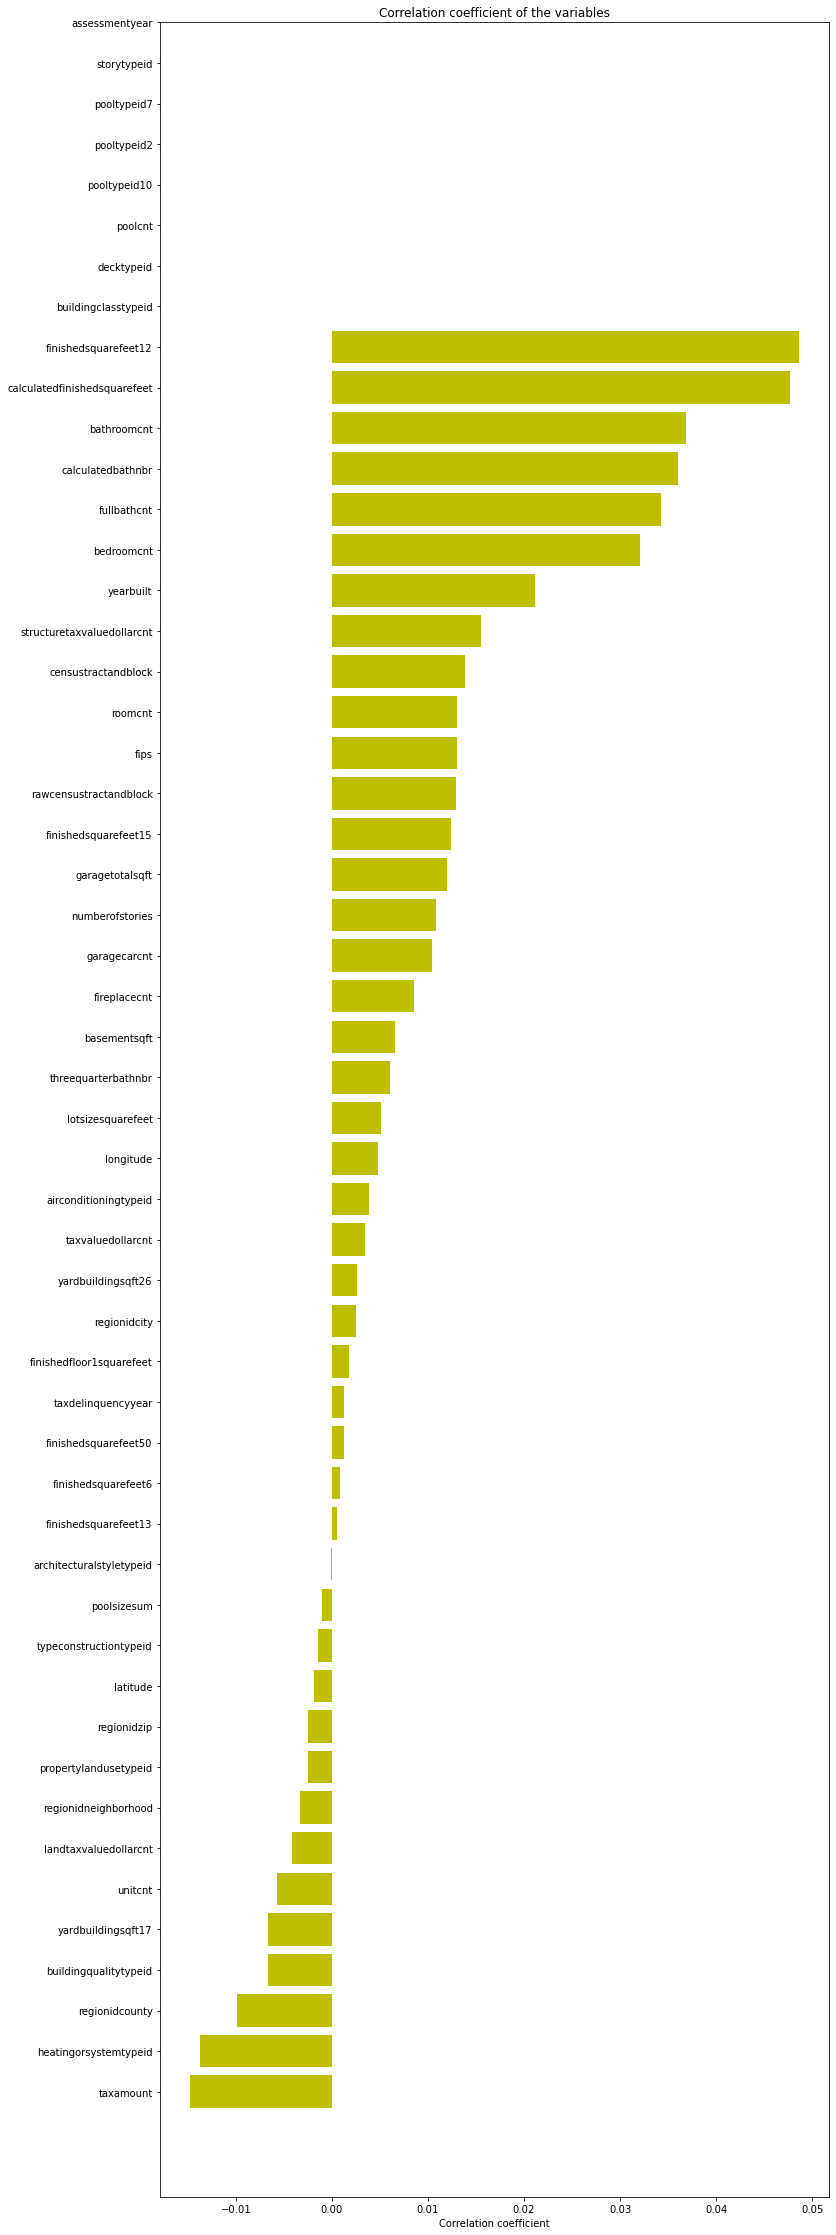

In [29]:
# just impute the missing values with mean values to compute correlation coefficients
mean_values = train_df.mean(axis=0)
train_df.fillna(mean_values, inplace=True)
train_df_new = train_df

# look at the correlation coefficient of each of these variables
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype == 'float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0, 1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Correlation coefficient of the variables')
plt.show()

The correlation of the target variable with the given set of variables are low overall.  
  
There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [30]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


Let us take the variables with high correlation values and then do some analysis on them.

In [32]:
corr_df_sel = corr_df[(corr_df['corr_values'] > 0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013733
43,yearbuilt,0.021178
4,bedroomcnt,0.032037
18,fullbathcnt,0.034269
7,calculatedbathnbr,0.036022
3,bathroomcnt,0.036866
10,calculatedfinishedsquarefeet,0.047661
11,finishedsquarefeet12,0.048613


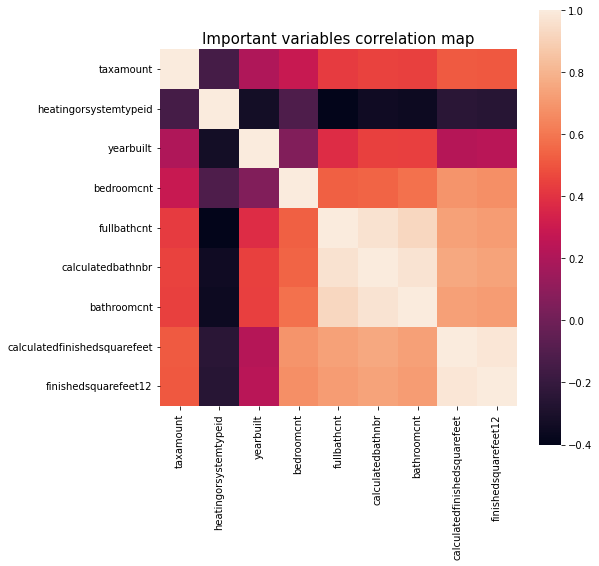

In [33]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, vmax=1., square=True)
plt.title('Important variables correlation map', fontsize=15)
plt.show()

The important variables themselves are very highly correlated. Let us now look at each of them.

**Finished SquareFeet 12:**  
  
Let us see how the finished square feet 12 varies with the log error.

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

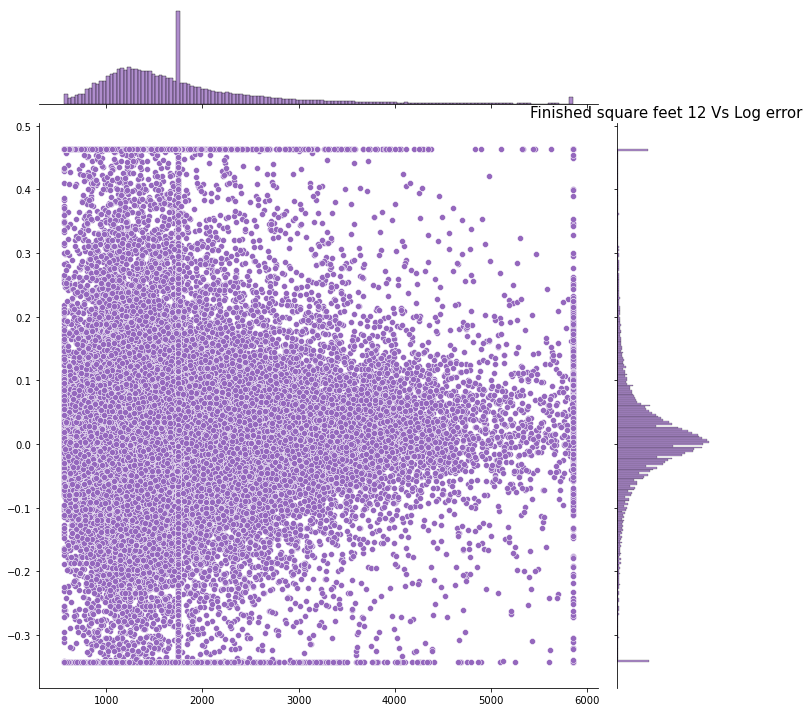

In [34]:
col = 'finishedsquarefeet12'

ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)

train_df[col].iloc[train_df[col] > ulimit] = ulimit
train_df[col].iloc[train_df[col] < llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title('Finished square feet 12 Vs Log error', fontsize=15)
plt.show()

Seems the range of logerror narrows down with increase in finished square feet 12 variable.  
Probably larger houses are easy to predict?

**Calculated finished square feet:**

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

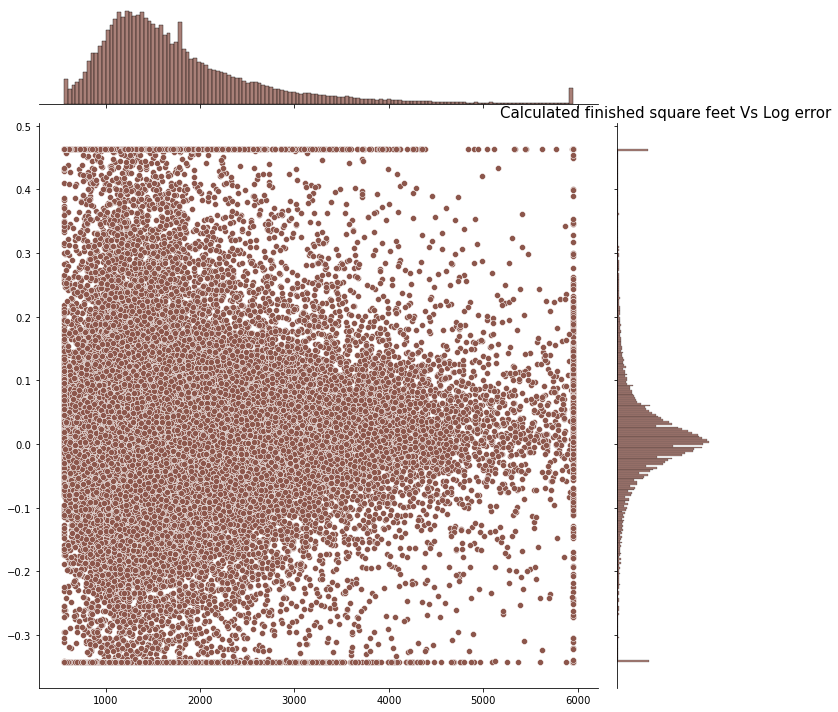

In [35]:
col = 'calculatedfinishedsquarefeet'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].iloc[train_df[col] > ulimit] = ulimit
train_df[col].iloc[train_df[col] < llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title('Calculated finished square feet Vs Log error', fontsize=15)
plt.show()

Here as well the distribution is very similar to the previous one. No wonder the correlation between the two variables are also high.

**Bathroom Count:**

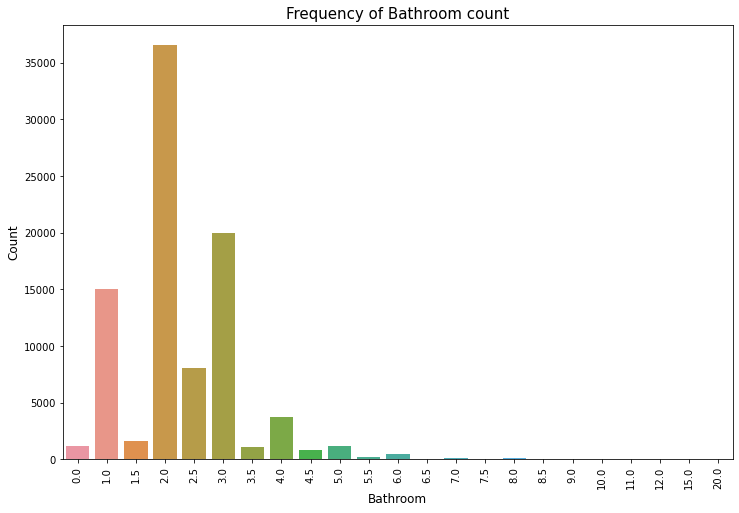

In [36]:
plt.figure(figsize=(12, 8))
sns.countplot(x='bathroomcnt', data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Bathroom count', fontsize=15)
plt.show()

Let us check how the log error changes based on this.

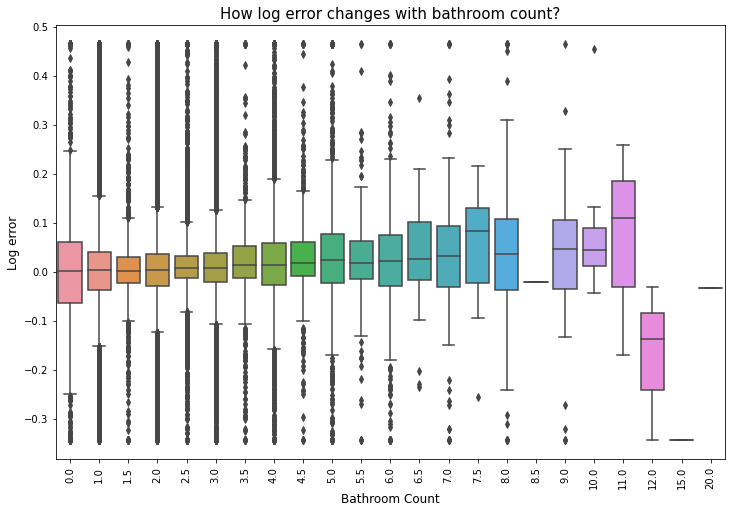

In [38]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='bathroomcnt', y='logerror', data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('How log error changes with bathroom count?', fontsize=15)
plt.show()

**Bedroom count:**

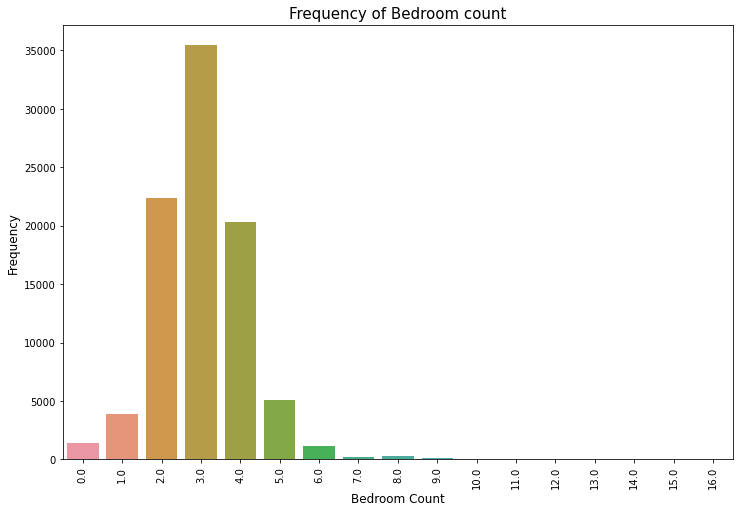

In [39]:
plt.figure(figsize=(12, 8))
sns.countplot(x='bedroomcnt', data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Bedroom count', fontsize=15)
plt.show()

**Bedroom count:**

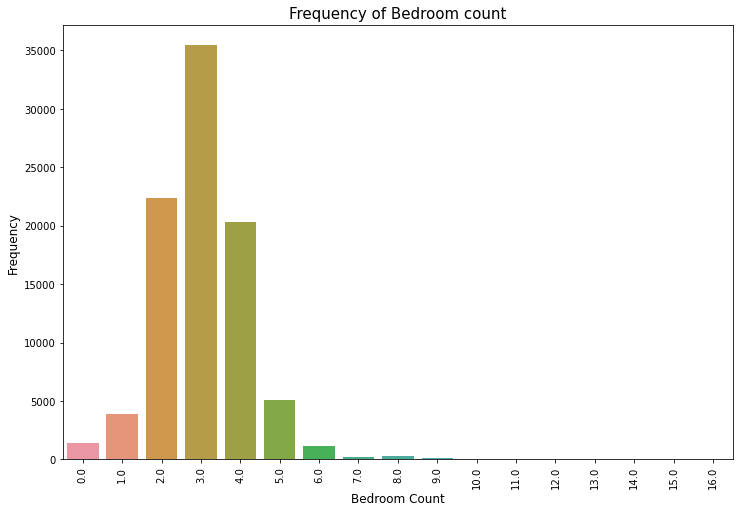

In [40]:
plt.figure(figsize=(12, 8))
sns.countplot(x='bedroomcnt', data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Bedroom count', fontsize=15)
plt.show()

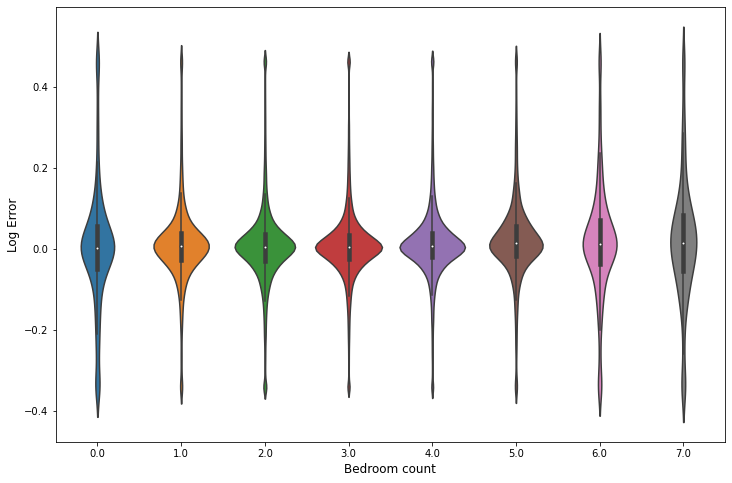

In [41]:
train_df['bedroomcnt'].iloc[train_df['bedroomcnt'] > 7] = 7
plt.figure(figsize=(12, 8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

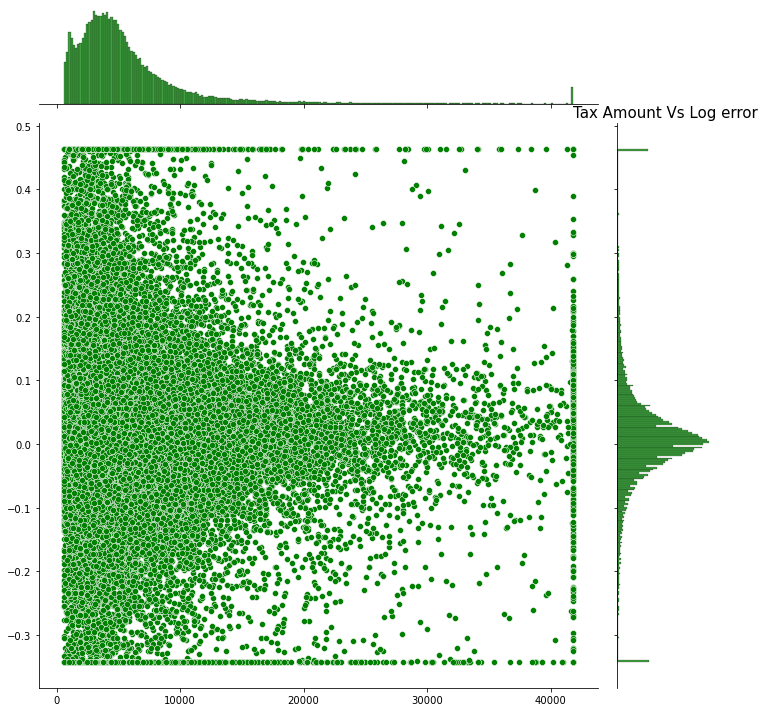

In [42]:
col = 'taxamount'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].iloc[train_df[col] > ulimit] = ulimit
train_df[col].iloc[train_df[col] < llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title('Tax Amount Vs Log error', fontsize=15)
plt.show()

**YearBuilt:**  
Let us explore how the error varies with the yearbuilt variable.

In [44]:
from plotnine import *

In [52]:
# ggplot(data=train_df, mapping=aes(x='yearbuilt', y='logerror')) + \
#     geom_point(color='steelblue', size=1) + \
#         stat_smooth()

R은 몰라서 에러를 해결 못했다.  
  
There is a minor incremental trend seen with respect to built year.  
  
Now let us see how the logerror varies with respect to latitude and longitude.

In [55]:
# ggplot(data=train_df, mapping=aes(x='latitude', y ='longitude', color='logerror'))+\
#     geom_point() + \
#     scale_color_gradient(low='red', high='blue')

얘도 뭔지 모르겠다.  
  
There are no visible pockets as such with respect to latitude or longitude at least with the naked eye.  
  
Let us take the variables with highest positive correlation and highest negative correlation to see if we can see some visible patterns.

In [ ]:
# ggplot(data=train_df, mapping=aes(x='finishedsquarefeet12', y ='taxamount', color='logerror'))+\
#     geom_point(alpha=0.7) + \
#     scale_color_gradient(low='pink', high='blue')

There are no visible patterns here as well. So this is going to be a hard competition to predict I guess.  
  
Just for fun, we will let the machine form some arbitary pattern for us.

In [ ]:
# ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
#     geom_now_its_art()

We had an understanding of important variables from the univariate analysis. But this is on a stand alone basis and also we have linearity assumption. Now let us build a non-linear model to get the important variables by building Extra Tree model.

In [57]:
train_y = train_df['logerror'].values
cat_cols = ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month'] + cat_cols, axis=1)
feat_names = train_df.columns.values

In [58]:
from sklearn import ensemble

In [59]:
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=1, random_state=0)
model.fit(train_df, train_y)

ExtraTreesRegressor(max_depth=30, max_features=0.3, n_estimators=25, n_jobs=1,
                    random_state=0)

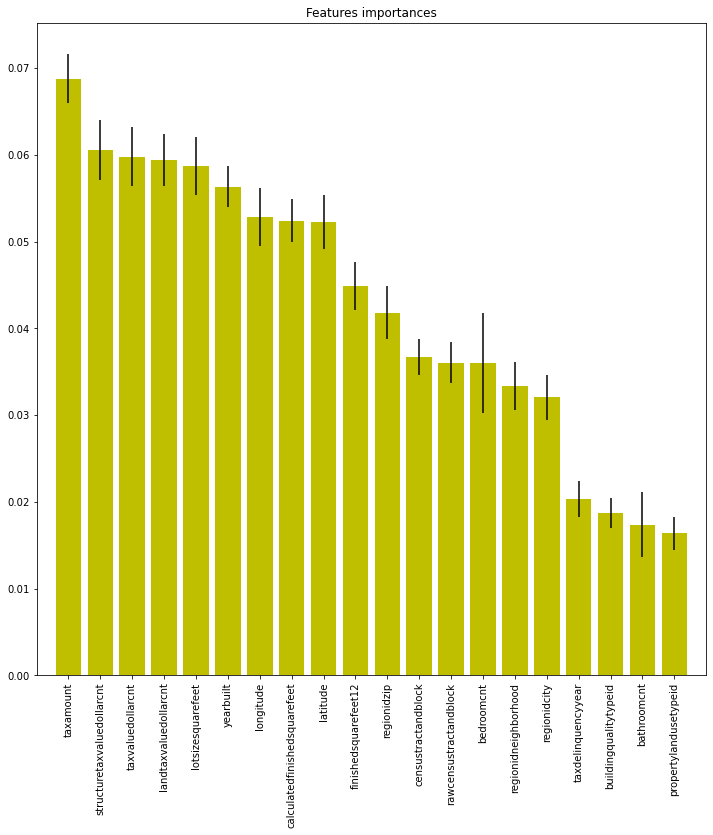

In [60]:
# plot the importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 12))
plt.title('Features importances')
plt.bar(range(len(indices)), importances[indices], color='y', yerr=std[indices], align='center')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Seems 'tax amount' is the most important variable followed by 'structure tax value dollar count' and 'land tax value dollor count'

In [61]:
import xgboost as xgb

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed': 0
}

In [62]:
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

: 

: 